# Forecasting Experiment on Solar Dataset

In [6]:
import os
import torch
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from engine.solver import Trainer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import load_datasets
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one, unnormalize_to_zero_to_one
import pathlib

In [7]:
MultivariateGrouper?


Init signature:
MultivariateGrouper(
    max_target_dim: Union[int, NoneType] = None,
    num_test_dates: Union[int, NoneType] = None,
    train_fill_rule: Callable = <function mean at 0x7f97bd82de50>,
    test_fill_rule: Callable = <function MultivariateGrouper.<lambda> at 0x7f970d735940>,
) -> None
Docstring:     
The MultivariateGrouper takes a univariate dataset and groups it into a
single multivariate time series. Therefore, this class allows the user to
convert a univariate dataset into a multivariate dataset without making a
separate copy of the dataset.

The Multivariate Grouper has two different modes:

Training: For training data, the univariate time series get aligned to the
earliest time stamp in the dataset. Time series will be left and right
padded to produce an array of shape (dim, num_time_steps)

Test: The test dataset might have multiple start dates (usually because
the test dataset mimics a rolling evaluation scenario). In this case,
the univariate dataset will be sp

In [10]:
local_dataset_path = pathlib.Path(r"/git/datasets/solar-energy")
dataset_path = pathlib.Path("/git/datasets/solar-energy")

# Load the dataset using GluonTS's load_datasets function
# Ensure the metadata.json file, as well as paths to train and test folders are correctly specified
dataset = load_datasets(metadata=dataset_path,  
train=dataset_path / "train",
    test=dataset_path / "test")


data_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test = [i for i in data_grouper(dataset.test)]
test = test[0]['target'].transpose(1,0)

train = [i for i in data_grouper(dataset.train)]
train = train[0]['target'].transpose(1,0)

data = np.concatenate([train, test], axis=0)
data = data[0:14016, 9:]
data = np.split(data, 73, 0)
data = np.array(data)

In [11]:
train = data[0:65].reshape(-1, data.shape[-1])
test = data[65:]

scaler = MinMaxScaler()
train_scaled = normalize_to_neg_one_to_one(scaler.fit_transform(train))
test_scaled = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)
test_scaled = normalize_to_neg_one_to_one(test_scaled)

In [12]:
class SolarDataset(Dataset):
    def __init__(self, data, regular=True, pred_length=72):
        super(SolarDataset, self).__init__()
        self.sample_num = data.shape[0]
        self.samples = data
        self.regular = regular
        self.mask = np.ones_like(data)
        self.mask[:, -pred_length:, :] = 0.
        self.mask = self.mask.astype(bool)

    def __getitem__(self, ind):
        x = self.samples[ind, :, :]
        if self.regular:
            return torch.from_numpy(x).float()
        mask = self.mask[ind, :, :]
        return torch.from_numpy(x).float(), torch.from_numpy(mask)

    def __len__(self):
        return self.sample_num

In [13]:
train_dataset = SolarDataset(train_scaled.reshape(65, -1, data.shape[-1]))
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True, pin_memory=True, sampler=None)

In [14]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = './Config/solar.yaml'
        self.save_dir = './forecasting_exp'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader={'dataloader':dataloader})

In [15]:
trainer.train()

loss: 0.066638: 100%|█████████████████████████████████████████████████| 1500/1500 [02:41<00:00,  9.31it/s]

training complete


In [16]:
_, seq_length, feat_num = test_scaled.shape
pred_length = 72

test_dataset = SolarDataset(test_scaled, regular=False, pred_length=pred_length)
real = scaler.inverse_transform(unnormalize_to_zero_to_one(test_scaled.reshape(-1, feat_num))).reshape(test_scaled.shape)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_scaled.shape[0], shuffle=False, num_workers=0, pin_memory=True, sampler=None)

sample, *_ = trainer.restore(test_dataloader, shape=[seq_length, feat_num], coef=1e-2, stepsize=5e-2, sampling_steps=200)
sample = scaler.inverse_transform(unnormalize_to_zero_to_one(sample.reshape(-1, feat_num))).reshape(test_scaled.shape)
mask = test_dataset.mask
mse = mean_squared_error(sample[~mask], real[~mask])
print(mse)

conditional sampling loop time step: 100%|██████████████████████████████| 200/200 [00:12<00:00, 15.73it/s]

423.8592038470817


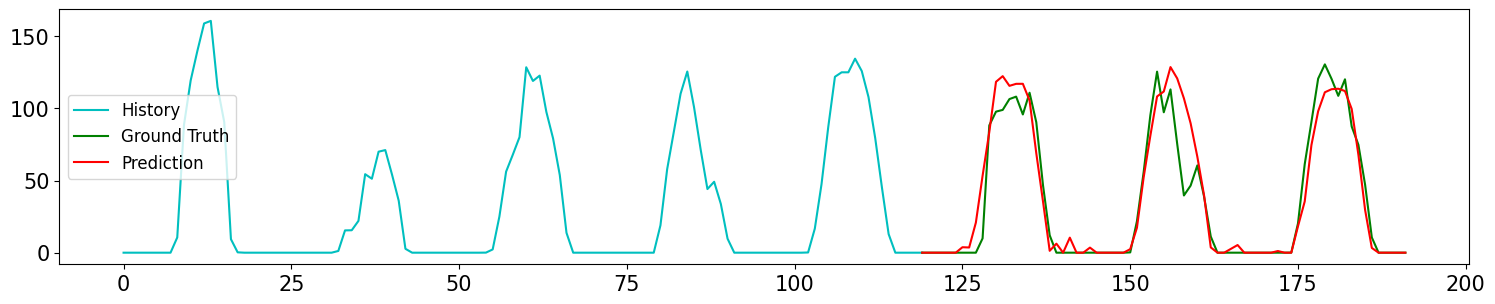

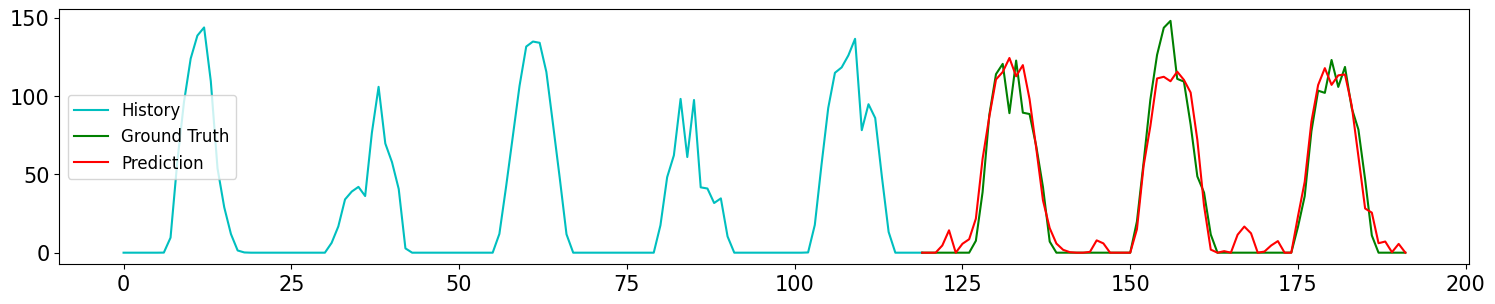

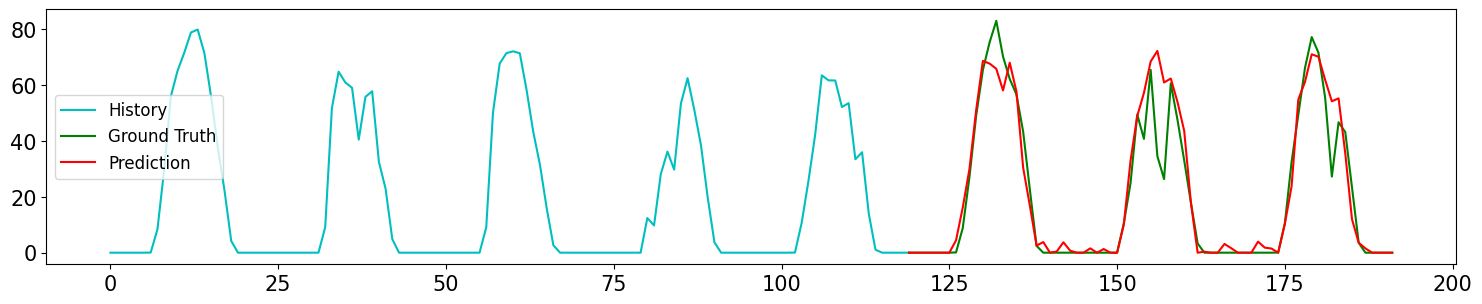

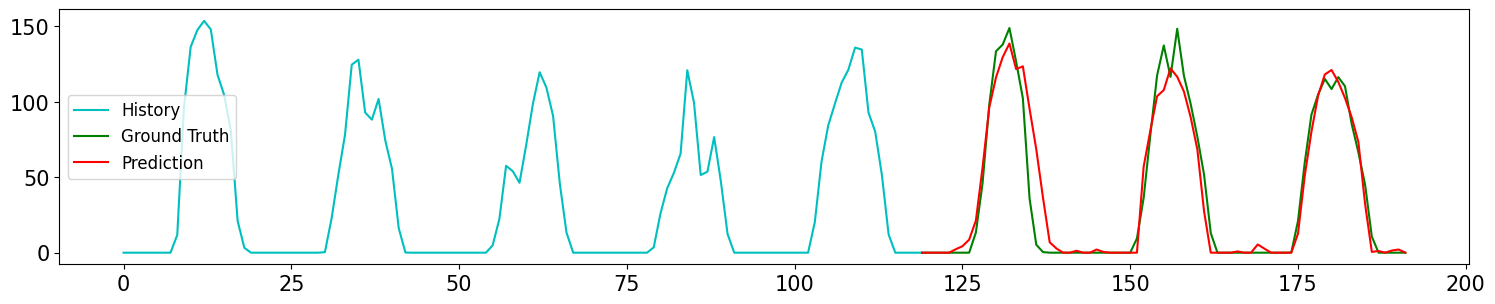

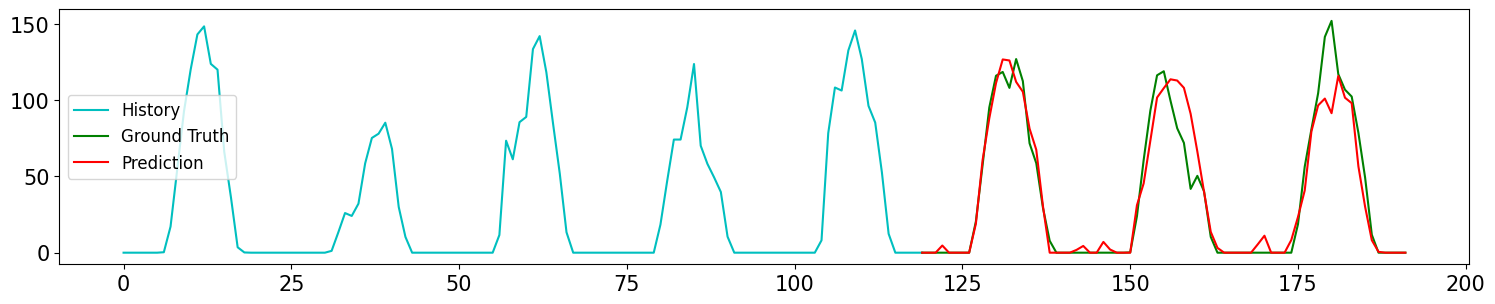

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 12

for idx in range(5):
    plt.figure(figsize=(15, 3))
    plt.plot(range(0, seq_length-pred_length), real[0, :(seq_length-pred_length), idx], color='c', linestyle='solid', label='History')
    plt.plot(range(seq_length-pred_length-1, seq_length), real[0, -pred_length-1:, idx], color='g', linestyle='solid', label='Ground Truth')
    plt.plot(range(seq_length-pred_length-1, seq_length), sample[0, -pred_length-1:, idx], color='r', linestyle='solid', label='Prediction')
    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    plt.legend()
    plt.show()